## Preparation
In this section, packages will be imported and the random seed will be set.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from IPython.display import display

ModuleNotFoundError: No module named 'seaborn'

In [3]:
rs = 290310
np.random.seed(rs)

## Ex.1 Loading and Preparing the Data
In this section, the data will be loaded into the project and will be manipulated into a manageble format for our analysis

In [4]:
df_path = 'data\cla4lsp22_bikez_curated.csv'
df_tot = pd.read_csv(df_path)


In [5]:
r = np.random.randint(0,3)
workdf = df_tot.loc[df_tot['Year']%3 == r]

In [6]:
feature_to_remove = ['Front brakes',
                     'Rear brakes', 
                     'Front tire',
                     'Rear tire',
                     'Front suspension',
                     'Rear suspension']

feature_to_remove = np.random.choice(feature_to_remove, 
                                     size=2,
                                     replace = False)
workdf = workdf.drop(columns = feature_to_remove)

print('Columns', feature_to_remove, 'have been dropped from the DataFrame')



Columns ['Rear tire' 'Front suspension'] have been dropped from the DataFrame


#### Missing values handling
Andiamo a vedere se i missing values nelle colonne categoriche hanno una particolare label:

In [7]:
categorical_columns = dict()
for col in workdf.iloc[:, 5:].columns: #for each feature (hence we exclude labels)
    if workdf[col].dtype == 'O': #if that feature is categorical
        workdf[col] = workdf[col].str.lower()#put all the entries as lowercase (avoid case sensitive conflicts)
        categorical_columns[col] = workdf[col].unique() #append its unique values into a dict entry

From a visual inspection missing categorical values are labeled as "Not Given/Unknown" (N.B. could also be written in lowercase "not given/unknown")

Let's now inspect how many rows have missing values and how many missing values are there for each row.

Text(0.5, 1.0, 'Pieplot of missing values')

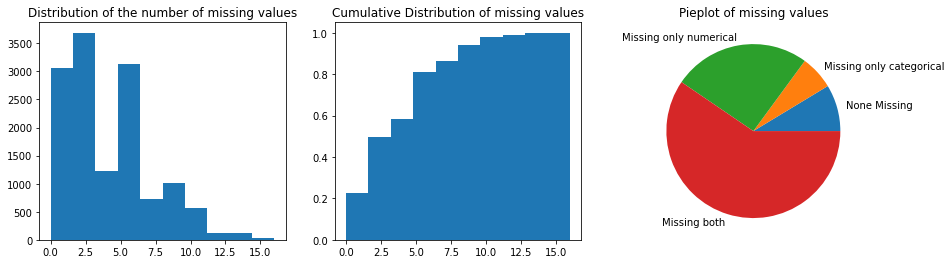

In [8]:
missing_categorical = np.zeros(len(workdf)) #array containing for each row the number of missing categorical attributes 
missing_numerical = np.zeros(len(workdf)) #array containing for each row the number of missing numerical attributes
missing_count = dict()
for col in workdf.iloc[:, 5:].columns: #for each feature (hence we exclude labels)

    if workdf[col].dtype == 'O': #if that feature is categorical
        tmp01 = (workdf[col].str.lower()=='not given/unknown')# array indicating if the value of the column is missing
        workdf.loc[tmp01, col] = np.nan #setting missing values as NaN
        tmp01 = tmp01.astype(int)
        missing_categorical = missing_categorical + tmp01
        missing_count[col] = sum(tmp01)
    else:
        tmp01 = workdf[col].isna().astype(int)
        missing_numerical = missing_numerical + tmp01
        missing_count[col] = sum(tmp01)


#  ------- Histogram and Pieplot -------

missing = missing_categorical + missing_numerical #array containing for each row the number of missing attributes

pie_label = ['None Missing', 'Missing only categorical', 'Missing only numerical', 'Missing both']
missing_categorical_bool = missing_categorical.astype(bool) #True if row contains at least one missing categorical value
missing_numerical_bool = missing_numerical.astype(bool) #True if row contains at least one missing numerical value

none_missing = np.logical_and(np.logical_not(missing_numerical_bool), np.logical_not(missing_categorical_bool)) #True if row contais all numerical and categorical values
missing_only_categorical = np.logical_and(missing_categorical_bool, np.logical_not(missing_numerical_bool)) #True if row misses only categorical data
missing_only_numerical = np.logical_and(missing_numerical_bool, np.logical_not(missing_categorical_bool)) #True if row misses only numerical data
missing_both = np.logical_and(missing_categorical_bool, missing_numerical_bool) #True if row misses both numerical and categorical data

pie_data = [none_missing.sum(), missing_only_categorical.sum(), missing_only_numerical.sum(), missing_both.sum()]

fig, axs= plt.subplots(1,3)
fig.set_size_inches(15,4)
axs[0].hist(missing)
axs[0].set_title('Distribution of the number of missing values')
axs[1].hist(missing, cumulative=True, density = True)
axs[1].set_title('Cumulative Distribution of missing values')
axs[2].pie(pie_data, labels = pie_label)
axs[2].set_title('Pieplot of missing values')


Text(0.5, 1.0, 'Missing values for each feature')

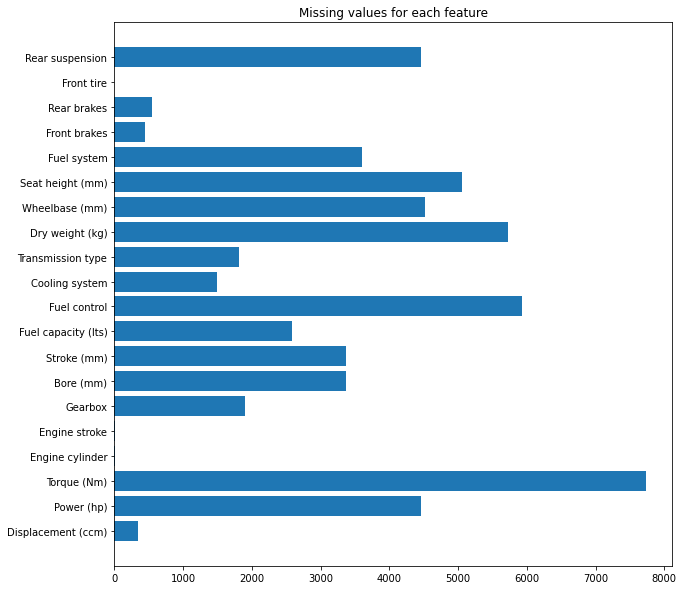

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.barh(list(missing_count.keys()), missing_count.values())
ax.set_title('Missing values for each feature')

idea:
1. togliamo le righe che hanno troppi missing values;
2. facciamo il replacement con la moda;
3. NON facciamo il replacement sulle colonne categoriche con tanti missing values;
4. Torque (Nm) ha praticamente tutti missing values, che sia da togliere direttamente dall'analisi?
    

In [10]:
missing_threshold = 11 
perc = sum(missing[missing>missing_threshold])/sum(missing)*100
workdf = workdf[missing<=missing_threshold]

print('Rows with more than', missing_threshold, 'missing values have been deleted.', f'{perc:.2f}%', 'of the data has been deleted')

#workdf.drop('Torque(Nm)') #TODO #2 da vedere se droppare la colonna torque

missing_threshold_perc = 0.33

for col in workdf.iloc[:, 5:].columns: #for each feature column
    if workdf[col].dtype == 'O': #if it's a categorical column
        if missing_count[col]/len(workdf)>missing_threshold_perc: #if missing values are above a threshold
            workdf[col] = workdf[col].fillna(value = 'other') #replace with a default value
            print("Missing values in the column", col, 'have been replaced with the value "other"')
        else:
            mode = min(workdf[col].mode())
            workdf[col]= workdf[col].fillna(value = mode) #replace with the mode
            #TODO #1 cosa fare quando la moda è essa stessa il valore "other"?
            print("Missing values in the column", col, 'have been replaced with the mode of the column:', mode)
    else:#if the column is numerical
        colmean=workdf[col].mean()
        workdf[col]=workdf[col].fillna(value = colmean) #replace with the mean
        print("Missing values in the column", col, 'have been replaced with the mean of the column:', colmean)

    


Rows with more than 11 missing values have been deleted. 6.24% of the data has been deleted
Missing values in the column Displacement (ccm) have been replaced with the mean of the column: 545.7325114503816
Missing values in the column Power (hp) have been replaced with the mean of the column: 50.74629083360646
Missing values in the column Torque (Nm) have been replaced with the mean of the column: 63.20781434599157
Missing values in the column Engine cylinder have been replaced with the mode of the column: single cylinder
Missing values in the column Engine stroke have been replaced with the mode of the column:  four-stroke
Missing values in the column Gearbox have been replaced with the mode of the column: 6-speed
Missing values in the column Bore (mm) have been replaced with the mean of the column: 72.45040776699028
Missing values in the column Stroke (mm) have been replaced with the mean of the column: 64.58373786407768
Missing values in the column Fuel capacity (lts) have been repl

In [11]:
#workdf['Transmission type'].fillna(value = workdf['Transmission type'].mode())
a = min(workdf['Transmission type'].mode())

### Outlier analysis

analisi degli outlier delle colonne numeriche


In [20]:
num_features = workdf.iloc[:, 5:].select_dtypes(np.number).columns #numerical features in the df
workdf[num_features].describe()
#TODO #3 outlier detection

,Displacement (ccm),Power (hp),Torque (Nm),Bore (mm),Stroke (mm),Fuel capacity (lts),Dry weight (kg),Wheelbase (mm),Seat height (mm)
count,13400.000000,13400.000000,13400.000000,13400.000000,13400.000000,13400.000000,13400.000000,13400.000000,13400.000000
mean,545.732511,50.746291,63.207814,72.450408,64.583738,13.079118,161.550133,1417.508044,791.621219
std,531.993158,42.809185,42.381844,16.510550,16.161480,5.479497,65.249708,140.801021,107.650357
min,25.000000,0.300000,1.500000,1.500000,0.000000,0.500000,15.100000,725.000000,39.000000
25%,125.000000,17.875000,63.207814,62.000000,55.000000,9.000000,126.000000,1370.000000,780.000000
50%,399.000000,50.746291,63.207814,72.450408,64.583738,13.079118,161.550133,1417.508044,791.621219
75%,798.000000,51.400000,63.207814,81.500000,69.000000,17.000000,161.550133,1470.000000,810.000000
max,8200.000000,689.000000,710.000000,176.000000,458.600000,50.000000,1000.000000,2489.000000,7501.000000


## Ex.2 Encoding of categorical data

Visualizziamo le features categoriche e di conseguenza prendiamo decisioni


In [12]:
display(categorical_columns)

{'Engine cylinder': array(['in-line four', 'single cylinder', 'twin', 'electric', 'v2',
        'four cylinder boxer', 'not given/unknown', 'v4', 'diesel',
        'square four cylinder', 'v8', 'in-line six', 'in-line three',
        'two cylinder boxer', 'v6', 'single disc wankel',
        'six cylinder boxer', 'v3', 'gas turbine', 'dual disc wankel',
        'radial'], dtype=object),
 'Engine stroke': array([' four-stroke', 'electric', ' two-stroke', 'not given/unknown',
        'diesel', 'square four cylinder', 'single disc wankel',
        'gas turbine', 'dual disc wankel', 'radial'], dtype=object),
 'Gearbox': array(['6-speed', 'automatic', '5-speed', 'not given/unknown', '1-speed',
        '3-speed', '4-speed', '7-speed', '2-speed', '4-speed with reverse',
        '10-speed', '5-speed with reverse', '3-speed automatic',
        '2-speed automatic', '100-speed'], dtype=object),
 'Fuel control': array(['not given/unknown', 'overhead valves (ohv)',
        'overhead cams (ohc)', 'si

Notiamo che tutte le feature categoriche hanno un normale encoding tranne le colonne "Front brakes" e "Rear brakes" che utilizzano il particolare encoding $\alpha . \beta \dots$

Usiamo il one-hot encoding perché le feature categoriche non hanno un ordinamento intrinseco quindi non possiamo enumerare le caratteristiche (evitiamo di generare un ordinamento fittizio delle features)

In [13]:
workdf_encoded = workdf.iloc[:, :5]

for col in workdf.iloc[:, 5:].columns: #for each feature column
    if workdf[col].dtype == 'O': #if that feature is categorical
        if col == 'Front brakes' or col=='Rear brakes': #if that feature requires special encoding
            workdf[col]=[entry.split(sep='. ') for entry in workdf[col]]#split every entry into list of categories
            mlb = MultiLabelBinarizer(sparse_output=True)#initialize a multilabel binarizer
            mlb_df = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(workdf[col]), #perform the multilabel encoding
                                                       index = workdf_encoded.index,
                                                       columns=[col + '_' + c for c in mlb.classes_])#generate a dataframe from the encoding
            workdf_encoded=workdf_encoded.join(mlb_df)#join the encoded df with the encoding dataframe                
        else:#if that feature doesn't require special encoding
          workdf_encoded = workdf_encoded.join(pd.get_dummies(workdf[col], prefix=col))#join the result of pd.get_dummies with the encoding df
    else:#if the feature is numerical
        workdf_encoded = workdf_encoded.join(workdf[col])#simply join it in the encoded df without performing encoding

In [14]:
Xworkdf = workdf_encoded.iloc[:, 5:]

## Ex.3 Preprocessing and PCA

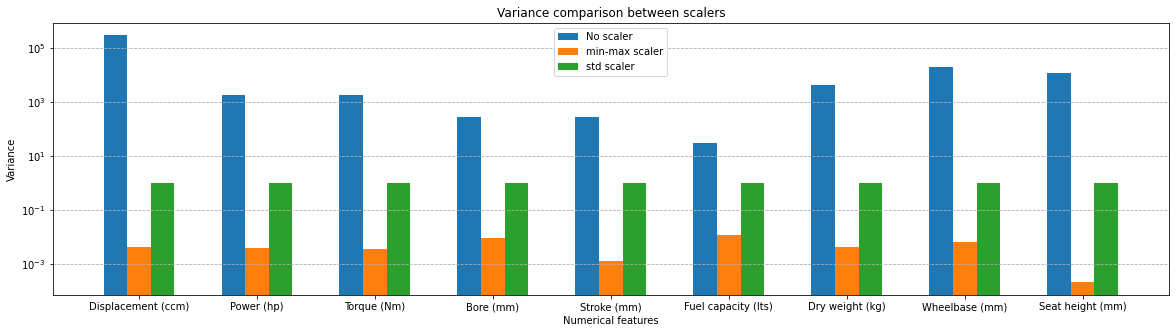

In [62]:
data_mat = Xworkdf.to_numpy()

scaler_mm = MinMaxScaler()
Xworkdf_mm = pd.DataFrame(scaler_mm.fit_transform(data_mat), index=Xworkdf.index, columns=Xworkdf.columns)

scaler_std = StandardScaler()
Xworkdf_std = pd.DataFrame(scaler_std.fit_transform(data_mat), index=Xworkdf.index, columns=Xworkdf.columns)

# variance comparison of numerical features

var_numerical = np.array(Xworkdf[num_features].var())
var_numerical_mm = np.array(Xworkdf_mm[num_features].var())
var_numerical_std = np.array(Xworkdf_std[num_features].var())

fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.grid(True, axis='y', linestyle='--')
labels = [l for l in num_features]
X_axis = np.arange(len(num_features))
bar1 = ax.bar(X_axis-0.2, var_numerical, 0.2, label = 'No scaler')
bar2 = ax.bar(X_axis, var_numerical_mm, 0.2, label = 'min-max scaler')
bar3 = ax.bar(X_axis+0.2, var_numerical_std, 0.2, label = 'std scaler')

ax.set_ylabel('Variance')
ax.set_yscale('log')
ax.set_title('Variance comparison between scalers')
ax.set_xlabel('Numerical features')
ax.set_xticks(X_axis)
ax.set_xticklabels(labels)

ax.legend()
#ax.bar_label(bar1, padding=2)
#ax.bar_label(bar2, padding=2)

plt.show()



##### TODO commentare 


.




















# ------ CODICE DI TEST------

In [121]:
%%script false --no-raise-error

#USATO PER FARE IL MULTILABEL ENCODING-------------NON SERVE PIù
def smart_onehot(data, idx=None, feature_name=None, sep=None):
    """
    Performs one-hot encoding when multiple categories are featured in each row
    Arguments:
        data: the dataframe column you want to encode
        feature_name: the name of the column
        sep: char separating multiple categories in each row
    Returns:
        A dataframe encoded with unique values as they appear in each row

    """
    feature_name = feature_name+'_'
    
    categories = data.unique() #array containing all unique categories as they appear in data
    categories_unique = np.array([]) #array that will contain only unique categories

    for c in categories:#for each category in the data
        for k in c.split(sep):#extract all the sub-categories and for each one
            categories_unique = np.append(categories_unique, k) #append it into the categories_unique array
    categories_unique = np.unique(categories_unique)#then extract the unique values from that array

    enc_matrix = np.zeros([len(data), len(categories_unique)]) #the encoding matrix
    enc_df = pd.DataFrame(enc_matrix, index = idx, columns=[feature_name+c for c in categories_unique]) #the resulting dataframe with the right column names (and prefix)

    i=0
    for r in data: #for each row of the column we are encoding
        for category in r.split(sep): #for each category we find inside the row
            enc_df.iloc[i].at[feature_name + category] = 1 #put to 1 the corresponding value in the encoding matrix
        i=i+1
    
    return enc_df

Couldn't find program: 'false'


In [122]:
%%script false --no-raise-error

#USATO PER FARE IL MULTILABEL ENCODING, NON SERVE PIù
workdf_encoded = workdf.iloc[:, :5]

for col in workdf.iloc[:, 5:].columns: #for each feature column
    if workdf[col].dtype == 'O': #if that feature is categorical
        if col == 'Front brakes' or col=='Rear brakes': #if that feature requires special encoding
            df_tmp = smart_onehot(workdf[col], idx=workdf.index, feature_name=col, sep='. ')#perform the special encoding            
            workdf_encoded = workdf_encoded.join(df_tmp) #join the special encoding with the encoding df     
        else:#if that features doesn't require special encoding
          workdf_encoded = workdf_encoded.join(pd.get_dummies(workdf[col], prefix=col))#join the result of pd.get_dummies with the encoding df
    else:#if the feature is numerical
        workdf_encoded = workdf_encoded.join(workdf[col])#simply join it in the encoded df without performing encoding


Couldn't find program: 'false'


In [123]:
display(workdf.iloc[1014].at['Rear brakes'])
display(workdf_encoded.iloc[1014].at['Rear brakes_floating disc'])

display(workdf.iloc[1014])
df1014 = workdf_encoded.iloc[1014]

['single disc', 'other']

0

Brand                                big dog
Model                                    k-9
Year                                    2010
Category                    Custom / cruiser
Rating                                   NaN
Displacement (ccm)                    1917.0
Power (hp)                         50.746291
Torque (Nm)                        63.207814
Engine cylinder                           v2
Engine stroke                    four-stroke
Gearbox                              6-speed
Bore (mm)                              104.8
Stroke (mm)                            111.1
Fuel capacity (lts)                     16.6
Fuel control           overhead valves (ohv)
Cooling system                           air
Transmission type                       belt
Dry weight (kg)                        318.0
Wheelbase (mm)                        2083.0
Seat height (mm)                       616.0
Fuel system               carburettor. other
Front brakes            [single disc, other]
Rear brake

In [124]:
## TEST DI ENCODING PARTICOLARE  SMART ONE-HOT##
from sklearn.preprocessing import MultiLabelBinarizer
test = pd.DataFrame(
    {
        "Feature 1": ['A', 'B', 'A. B', 'A', 'C', 'C. A'],
        "Feature 2": ['a', 'b', 'a', 'a. c. b', 'c', 'c']
    }
)
display(test)

test['Feature 1']=[entry.split(sep='. ') for entry in test['Feature 1']]
display(test)

mlb = MultiLabelBinarizer(sparse_output=False)
mlb.fit_transform(test['Feature 1'])
# categories = test['Feature 1'].unique()
# categories_unique = np.array([])
# for c in categories:
#     for k in c.split('. '):
#         categories_unique = np.append(categories_unique, k)
# categories_unique = np.unique(categories_unique)
# display(categories_unique) #un array delle categorie uniche

# enc_matrix = np.zeros([len(test), len(categories_unique)])
# enc_df = pd.DataFrame(enc_matrix, columns=['Feature 1_'+c for c in categories_unique])


# i = 0
# for r in test['Feature 1']:# for each row of the colum we are encoding
#     for category in r.split('. '): #for each category we find inside the row
#         enc_df.loc[i].at['Feature 1_'+category] = 1 #put to 1 the corresponding value in the encoding matrix 
#     i = i+1

# display(enc_df)

# #enc_df contiene l'encoding della colonna 'feature 1' 



,Feature 1,Feature 2
0,A,a
1,B,b
2,A. B,a
3,A,a. c. b
4,C,c
5,C. A,c


,Feature 1,Feature 2
0,[A],a
1,[B],b
2,"[A, B]",a
3,[A],a. c. b
4,[C],c
5,"[C, A]",c


array([[1, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 1]])

In [125]:

np.array(['A', 'B', 'C']).T

array(['A', 'B', 'C'], dtype='<U1')